In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def gma(data, window_size):
    """
    Calculate the geometric moving average for a given data series.
    
    Parameters:
        data (list or numpy array): The input data series.
        window_size (int): The size of the moving window.
    
    Returns:
        list: Smoothed data using geometric moving average.
    """
    gma = []
    for i in range(len(data)):
        if i < window_size - 1:
            # Not enough data for a full window, append NaN
            gma.append(np.nan)
        else:
            # Calculate geometric mean for the current window
            window = data[i - window_size + 1:i + 1]
            gmean = np.prod(window) ** (1 / window_size)
            gma.append(gmean)
    return np.array(gma)

#Load data
raw_dataset= pd.read_csv('data.csv', na_values='?')
raw_dataset.pop('A')
ds = raw_dataset.copy()

#Preprocess data
ds= ds.drop(ds[ds['model'] != 'T_23'].index)
ds.pop('model')
#Create copys for min and T variables
min= ds['min']
t= ds['T']

#Get the initial temperature for each row and discart rows with null values
ds['Ti']= ds['T'].shift(1)
ds= ds.dropna()

#Split tran and test sets
train= ds.sample(frac=0.8, random_state=0)
test= ds.drop(train.index)

#Get data stats
train_stats = train.describe()
train_stats.pop('T')
train_stats = train_stats.transpose()

#Pop the output from the dataset
train_labels = train.pop('T')
test_labels = test.pop('T')

#Normalize data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train)
normed_test_data = norm(test)

#Build model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  
  return model

model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Run the model
EPOCHS = 1000
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

c:\Users\Josè Castillo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
907,19.828665,3.352298,19.828665,394.371399,14.592006,394.371399,907
908,19.815292,3.426904,19.815292,407.065704,14.891994,407.065704,908
909,19.821104,3.354287,19.821104,393.834229,14.579453,393.834229,909
910,19.809401,3.422739,19.809401,407.047546,14.889654,407.047546,910
911,19.824234,3.353939,19.824234,393.891541,14.577861,393.891541,911


In [9]:
#Evaluate the model
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:.2f} °C".format(mae))



1/1 - 0s - 49ms/step - loss: 1157.6239 - mae: 19.0592 - mse: 1157.6239
Testing set Mean Abs Error: 19.06 °C


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


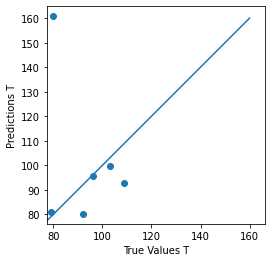

In [12]:
#Test the model
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values T')
plt.ylabel('Predictions T')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-160, 160], [-160, 160])

In [5]:
model.save('YuriCPC_061224.keras')